[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution

## Review

In module 3, we went in-depth on `human-in-the loop`, showing 3 common use-cases:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

## Goals

This module will build on `human-in-the-loop` as well as the `memory` concepts discussed in module 2.

We will dive into `multi-agent` workflows and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

We'll start with [parallelization](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches).

## Fan out and fan in

Let's build a simple linear graph that over-writes the state at each step.

In [1]:
%%capture --no-stderr
%pip install -U  langgraph langgraph_tavily wikipedia langchain_openai langchain_community langgraph_sdk

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

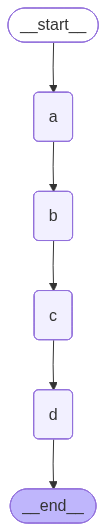

In [3]:
from IPython.display import Image, display

from typing import Any, List
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    # Note, no reducer function
    state: List[str]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
        
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}
    

builder = StateGraph(State)

# adding nodes
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# adding edges
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

We over-write state, as expected.

In [4]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

Now, let's run `b` and `c` in parallel. 

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

Then the state updates are applied at the end of each step.

Let's run it.

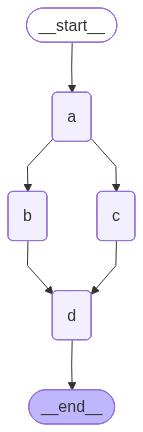

In [5]:
builder = StateGraph(State)

# adding nodes
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# adding edges
builder.add_edge(START, "a")

# fan-out
builder.add_edge("a", "b")
builder.add_edge("a", "c")

# fan-ing
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**We see an error**! 

This is because both `b` and `c` are writing to the same state key / channel in the same step. 

In [6]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occured: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occured: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key. 

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

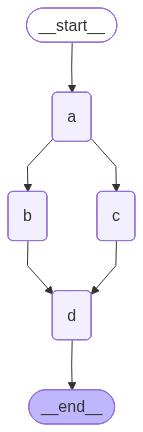

In [7]:
import operator
from typing import Annotated

class State(TypedDict):
    # reducer function for making append-only
    state: Annotated[list, operator.add]
    
# same graph as before
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

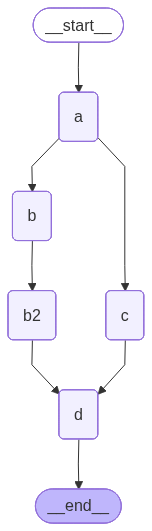

In [9]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`. 

In [10]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**. 

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

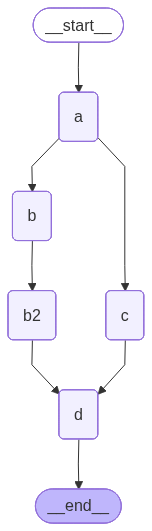

In [11]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

Now, the reducer sorts the updated state values!

The `sorting_reducer` example sorts all values globally. We can also: 

1. Write outputs to a separate field in the state during the parallel step
2. Use a "sink" node after the parallel step to combine and order those outputs
3. Clear the temporary field after combining

<!-- See the [~docs~](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting) [docs](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches) for more details.-->


## Working with LLMs

Now, lets add a realistic example! 

We want to gather context from two external sources (Wikipedia and Web-Search) and have an LLM answer a question.

In [13]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5-nano", temperature=0) 

In [14]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [15]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

In [16]:
import sys
print(sys.executable)


/Users/koushalsmodi/Desktop/MachineLearning/MachineLearningProjects/LangGraph/lca-lc-foundations/.venv/bin/python


In [17]:
import sys
!{sys.executable} -m pip install wikipedia


/Users/koushalsmodi/Desktop/MachineLearning/MachineLearningProjects/LangGraph/lca-lc-foundations/.venv/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/Users/koushalsmodi/Desktop/MachineLearning/MachineLearningProjects/LangGraph/lca-lc-foundations/.venv/lib/python3.11/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


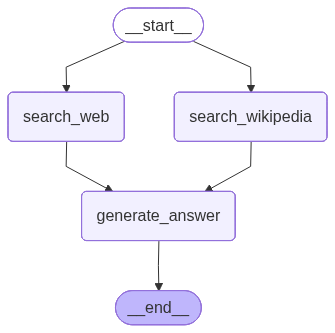

In [18]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_tavily import TavilySearch  # updated since filming
from tavily import TavilyClient

tavily_client = TavilyClient()

def search_web(state):
    """ Retrieve docs from web search """

    search_results = tavily_client.search(query=state['question'], max_results=5)
    
    # Extract the results list from the response
    results = search_results.get('results', [])
    
    if results:
        # Each result is a dict with 'url', 'content', 'title', etc.
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc.get("url", "")}" title="{doc.get("title", "")}">\n{doc.get("content", "")}\n</Document>'
                for doc in results
            ]
        )
    else:
        formatted_search_docs = "<Document>\nNo results found.\n</Document>"

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "How were Nvidia's Q2 2025 earnings"})
result['answer'].content

'From the context provided, Nvidia’s Q2 2025 earnings looked mixed but leaning positive overall:\n\n- Revenue beat: Nvidia guided to 33.1 billion in total revenue, about 1 billion above what analysts expected.\n- Data Center weakness: Data Center revenue missed forecasts for a second straight quarter, tempering the otherwise upbeat results.\n- Big capex wave: Capex rose sharply, with spending increasing from about 73 billion in Q1 to 90 billion in Q2, signaling ongoing aggressive AI-infrastructure investment.\n- China/S2H2 shipments: CFO noted no H2O (AI hardware) shipments to China in the quarter; potential shipments of 2–5 billion could flow if restrictions ease, but that revenue was not included in the Q3 forecast.\n- Outlook and sentiment: Nvidia stayed bullish on long-term AI infrastructure demand (expected trillions in AI infra spending by 2030), with robotics showing some growth. The stock dipped after hours despite the beat, reflecting the mixed signal from the data-center miss